# Part 3: Advanced Text Processing - LDA and BERTopic Topic Modeling

### LDA
Latent Dirichlet Allocation (LDA) topic model using gensim to find topics based on word co-occurrence.

In [113]:
import spacy
spacy.cli.download("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 36.6 MB/s  0:00:00eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [114]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.makedirs('outputs', exist_ok=True)

from spacy import displacy
from bertopic import BERTopic
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis.gensim_models
from gensim.corpora.dictionary import Dictionary

plt.style.use('seaborn-v0_8-dark') 

sou = pd.read_csv('data/SOTU.csv')
nlp = spacy.load('en_core_web_sm')

def preprocess_text(text): 
    doc = nlp(text) 
    return [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and not token.is_space and len(token.lemma_) > 3]

In [5]:
# Process all texts - takes ~ 5 minutes to run
processed_docs = sou['Text'].apply(preprocess_text)

In [115]:
# Build dictionary from processed_docs, which is a list of tokens extracted from our speeches
dic = Dictionary(processed_docs)
dic.filter_extremes(no_below=5, no_above=0.5)
corpus = [dic.doc2bow(doc) for doc in processed_docs]

In [116]:
# train LDA model with 18 topics
lda_model = LdaModel(
    corpus=corpus,
    id2word=dic,
    num_topics=18,
    random_state=42,
    passes=10
)

In [117]:
# top 10 words for each topic
print("\n--- LDA Topics ---") 
for idx, topic in lda_model.print_topics(-1): 
    print(f"Topic: {idx} \nWords: {topic}\n")


--- LDA Topics ---
Topic: 0 
Words: 0.004*"cent" + 0.004*"june" + 0.004*"gold" + 0.003*"island" + 0.003*"silver" + 0.003*"bond" + 0.003*"method" + 0.003*"convention" + 0.003*"indian" + 0.003*"note"

Topic: 1 
Words: 0.008*"depression" + 0.007*"program" + 0.007*"recovery" + 0.006*"budget" + 0.006*"unemployment" + 0.006*"loan" + 0.006*"activity" + 0.006*"farm" + 0.005*"emergency" + 0.005*"cent"

Topic: 2 
Words: 0.008*"dictator" + 0.005*"expression" + 0.004*"british" + 0.004*"1914" + 0.003*"impressive" + 0.003*"actual" + 0.003*"revolution" + 0.003*"schedule" + 0.003*"continent" + 0.003*"partisanship"

Topic: 3 
Words: 0.008*"forest" + 0.007*"corporation" + 0.005*"judge" + 0.005*"wrong" + 0.005*"interstate" + 0.004*"employee" + 0.003*"bureau" + 0.003*"body" + 0.003*"mountain" + 0.003*"island"

Topic: 4 
Words: 0.017*"program" + 0.014*"soviet" + 0.009*"1980" + 0.009*"u.s." + 0.008*"area" + 0.007*"major" + 0.006*"goal" + 0.006*"commitment" + 0.006*"challenge" + 0.006*"nuclear"

Topic: 5 
W

In [118]:
# topic distribution for the first speech
lda_model.get_document_topics(corpus[0])

[(11, np.float32(0.99942815))]

In [120]:
# visualization using pyLDAvis
pyLDAvis.enable_notebook()
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dic)
pyLDAvis.save_html(lda_display, 'outputs/lda_visualization.html')
pyLDAvis.display(lda_display)

### BERTopic
Use BERTopic to leverage transformer embeddings (BERT), clustering, and semantic similarity to discover conceptually coherent topics.

In [121]:
docs = sou['Text'].to_list()

In [126]:
# train the model - takes ~ 30 seconds to run
topic_model = BERTopic(min_topic_size=3, calculate_probabilities=True)
topics, probs = topic_model.fit_transform(docs)

In [127]:
# remove stop words from the topics
vectorizer_model = CountVectorizer(stop_words="english")
topic_model.update_topics(docs, vectorizer_model=vectorizer_model)
topics, _ = topic_model.fit_transform(docs)

In [128]:
# top 10 words for each topic
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,70,-1_government_states_united_congress,"[government, states, united, congress, year, p...",[\nTo the Senate and House of Representatives:...
1,0,26,0_world_new_people_years,"[world, new, people, years, american, year, na...","[\nMr. President, Mr. Speaker, Members of the ..."
2,1,15,1_states_united_government_public,"[states, united, government, public, congress,...",[\nFellow-Citizens of the Senate and House of ...
3,2,12,2_world_nations_peace_soviet,"[world, nations, peace, soviet, economic, nati...","[\nMr. President, Mr. Speaker, Members of the ..."
4,3,12,3_government_states_united_public,"[government, states, united, public, congress,...",[\nFellow-Citizens of the Senate and House of ...
5,4,12,4_government_states_united_year,"[government, states, united, year, law, congre...",[\nTo the Senate and House of Representatives:...
6,5,12,5_america_american_americans_people,"[america, american, americans, people, tonight...",[\nThe President. Mr. Speaker——\n[At this poin...
7,6,11,6_government_work_public_congress,"[government, work, public, congress, great, la...",[\nTo the Senate and House of Representatives:...
8,7,9,7_national_government_federal_congress,"[national, government, federal, congress, publ...",[\nGENTLEMEN OF THE CONGRESS:\nSince I last ha...
9,8,9,8_states_government_united_constitution,"[states, government, united, constitution, con...",[\nFellow-Citizens of the Senate and of the Ho...


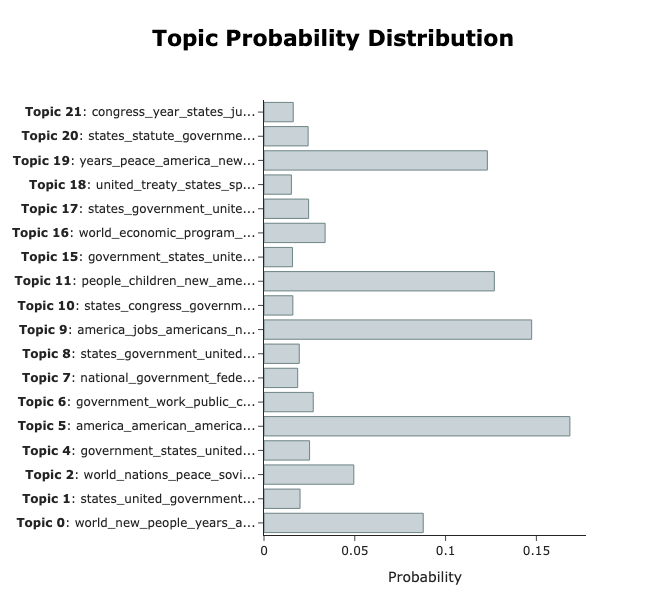

In [130]:
# output the topic distribution for the first speech
topic_distr, _ = topic_model.approximate_distribution(docs)
dist_fig = topic_model.visualize_distribution(topic_distr[0])
dist_fig.write_html("outputs/topic_distribution_doc0.html")
dist_fig

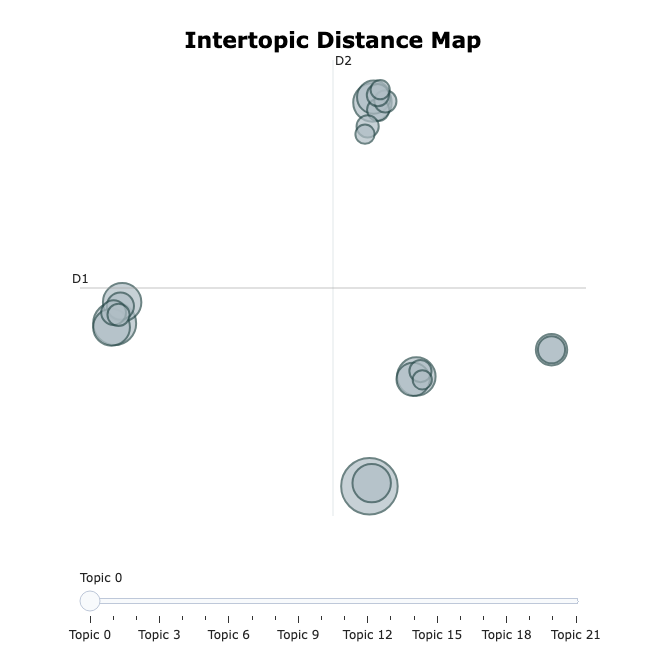

In [132]:
# visualize the topics
topics_fig = topic_model.visualize_topics()
topics_fig.write_html("outputs/topic_overview.html")
topics_fig